In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -U vega_datasets notebook vega

Requirement already up-to-date: vega_datasets in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: notebook in /usr/local/lib/python3.7/dist-packages (6.3.0)
Requirement already up-to-date: vega in /usr/local/lib/python3.7/dist-packages (3.4.0)


# 필요한 라이브러리 import

In [3]:
import numpy as np 
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
import math

from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

import IPython
from IPython.display import display
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns

import altair as alt
alt.renderers.enable('notebook')
from IPython.display import HTML

# fastai_structured.py import안되서 통째로 들고옴

In [4]:
import fastai_structured

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# 구글 드라이브 마운트

In [5]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 데이터 불러오기

In [6]:
%%time
# train_id = pd.read_csv("/gdrive/MyDrive/data/ieee-fraud-detection/test_identity.csv")
train_trans = pd.read_csv("/gdrive/MyDrive/data/ieee-fraud-detection/train_transaction.csv")
# test_id = pd.read_csv("/gdrive/MyDrive/data/ieee-fraud-detection/test_identity.csv")
test_trans = pd.read_csv("/gdrive/MyDrive/data/ieee-fraud-detection/test_transaction.csv")

CPU times: user 35.7 s, sys: 6.4 s, total: 42.1 s
Wall time: 46.9 s


In [7]:
%%time
# df_train=train
# df_test=test
df_train=train_trans
df_test=test_trans

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


# 메모리 사이즈 줄이기

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
%%time
# df_train = reduce_mem_usage(train)
# df_test = reduce_mem_usage(test)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
CPU times: user 1min 17s, sys: 1.65 s, total: 1min 19s
Wall time: 1min 19s


In [10]:
print(df_train.shape)
print(df_test.shape)

(590540, 394)
(506691, 393)


In [11]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.0000,280.000000,0.0000,77.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2636.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.0000,1058.000000,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,282.5000,282.500,282.5000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.9375,183.850006,67.9375,67.949997,67.9375,183.875,67.9375,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

## transaction의 칼럼
- TransactionDT: 주어진 reference datetime의 timedelta (실제 타임 스탬프 아님)
- isFraud: 사기인지 아닌지
- TransactionAMT: 거래 결제 금액 (USD)
- ProductCD: 제품 코드, 각 거래에 대한 제품
- card1 - card6: 카드 유형, 카드 카테고리, 발급 은행, 국가 등과 같은 결제 카드 정보
- addr1, addr2: 주소
- P_emaildomain: 구매자 이메일 도메인
- R_emaildomain: 수신자 이메일 도메인
- C1 - C14: 결제 카드와 관련된 것으로 확인 된 주소 수 등과 같은 계산. 실제 의미는 마스킹됨.
- D1-D15: 이전 거래 사이의 날짜 등과 같은 timedelta
- M1 - M9: 카드의 이름 및 주소 등의 매치

In [13]:
# 모든 칼럼 출력
print(df_train.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

# 데이터 분포
거래 사기 비율이 매우 불균형적임

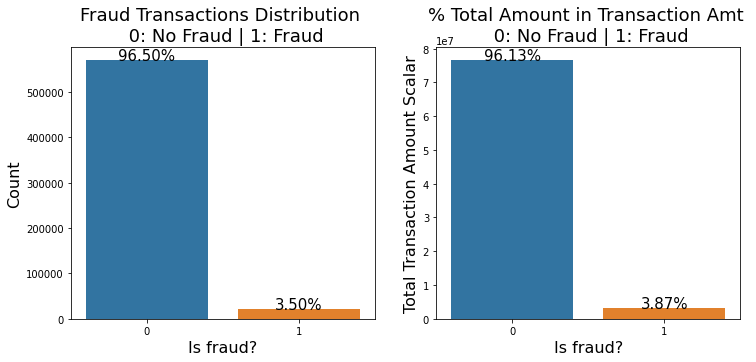

In [14]:
df_train['TransactionAmt'] = df_train['TransactionAmt'].astype(float)
total = len(df_train)
total_amt = df_train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=df_train)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    percent_amt = (df_train.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

In [15]:
df_train[['isFraud']].describe()

,isFraud
count,590540.000000
mean,0.034990
std,0.183755
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
df_train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


# 결측치 확인

In [17]:
df_train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [18]:
missing_values_count = df_train.isnull().sum()
print (missing_values_count[0:20])
# print (missing_values_count[:])
total_cells = np.product(df_train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
dtype: int64
% of missing data =  41.073431200111266


# TransactionAmt분포 확인
## 로그를 취해주면 정규분포가 되는 것을 확인
## ECDF(경험적 누적분포함수)를 통해 거래 결재 금액이 높을수록 사기일 확률 높음

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


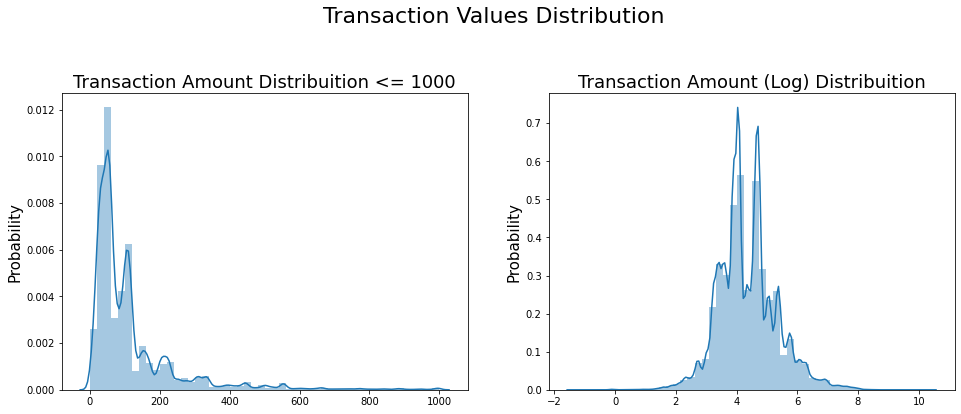

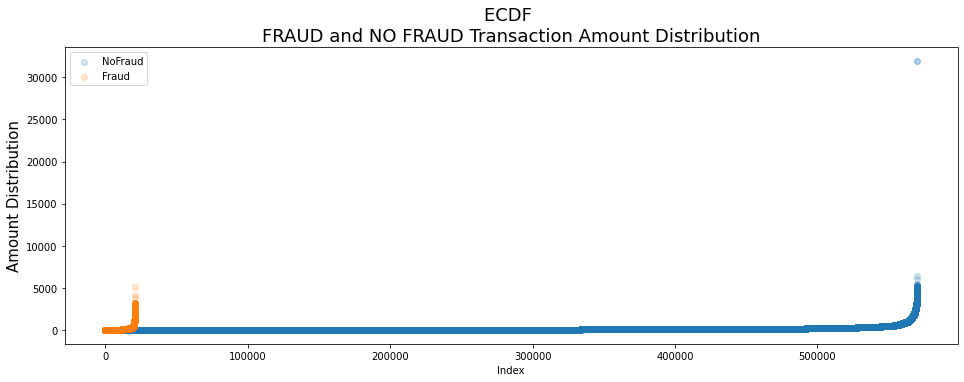

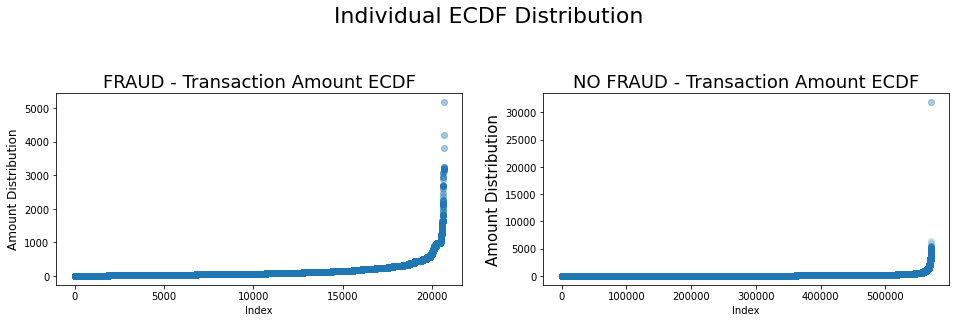

In [19]:
# ECDF는 경험적 누적분포 함수라고 부르고, 서로 다른 표본들의 분포를 비교할 때 많이 사용하고, 각 집단의 백분위를 추정할 수 있다.
# y축은 x축의 값이 전체 데이터에서 차지하는 비율을 의미
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_train[df_train['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_train['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))

plt.subplot(212)
g4 = plt.scatter(range(df_train[df_train['isFraud'] == 0].shape[0]),
                 np.sort(df_train[df_train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_train[df_train['isFraud'] == 1].shape[0]),
                 np.sort(df_train[df_train['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(df_train[df_train['isFraud'] == 1].shape[0]), 
                 np.sort(df_train[df_train['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_train[df_train['isFraud'] == 0].shape[0]),
                 np.sort(df_train[df_train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

# feature engineering
## TransAmt, D15, email을 중점으로
### 도메인 지식으로 접근했을때 개선의 여지가 크다는 것으로 해봄. FE는 많이 만들수록 좋고 그중 일부는 성능 개선에 도움이 되나 확실치 않고 정해진 기준도 없음..;

In [20]:
# # 평균, 표준편차 집계
# df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
# df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
# df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
# df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

In [21]:
# 평균, 표준편차 집계
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

df_train['D15_to_mean_card1'] = df_train['D15'] / df_train.groupby(['card1'])['D15'].transform('mean')
df_train['D15_to_mean_card4'] = df_train['D15'] / df_train.groupby(['card4'])['D15'].transform('mean')
df_train['D15_to_std_card1'] = df_train['D15'] / df_train.groupby(['card1'])['D15'].transform('std')
df_train['D15_to_std_card4'] = df_train['D15'] / df_train.groupby(['card4'])['D15'].transform('std')

df_test['D15_to_mean_card1'] = df_test['D15'] / df_test.groupby(['card1'])['D15'].transform('mean')
df_test['D15_to_mean_card4'] = df_test['D15'] / df_test.groupby(['card4'])['D15'].transform('mean')
df_test['D15_to_std_card1'] = df_test['D15'] / df_test.groupby(['card1'])['D15'].transform('std')
df_test['D15_to_std_card4'] = df_test['D15'] / df_test.groupby(['card4'])['D15'].transform('std')

df_train['D15_to_mean_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('mean')
df_train['D15_to_mean_addr2'] = df_train['D15'] / df_train.groupby(['addr2'])['D15'].transform('mean')
df_train['D15_to_std_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('std')
df_train['D15_to_std_addr2'] = df_train['D15'] / df_train.groupby(['addr2'])['D15'].transform('std')

df_test['D15_to_mean_addr1'] = df_test['D15'] / df_test.groupby(['addr1'])['D15'].transform('mean')
df_test['D15_to_mean_addr2'] = df_test['D15'] / df_test.groupby(['addr2'])['D15'].transform('mean')
df_test['D15_to_std_addr1'] = df_test['D15'] / df_test.groupby(['addr1'])['D15'].transform('std')
df_test['D15_to_std_addr2'] = df_test['D15'] / df_test.groupby(['addr2'])['D15'].transform('std')

In [22]:
# email mapping
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


In [23]:
# log값 취하기
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

In [24]:
# df_train.loc[df_train.card3.isin(df_train.card3.value_counts()[df_train.card3.value_counts() < 200].index), 'card3'] = "Others"
# df_train.loc[df_train.card5.isin(df_train.card5.value_counts()[df_train.card5.value_counts() < 300].index), 'card5'] = "Others"

In [25]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,2987000,0,86400,4.226834,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194638,0.257761,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,nan,NaN,nan
1,2987001,0,86401,3.367296,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123780,0.219053,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,google,com,NaN,nan
2,2987002,0,86469,4.077537,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608151,0.443070,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.721680,1.486472,1.522249,microsoft,com,NaN,nan
3,2987003,0,86499,3.912023,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405136,0.377678,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.606445,0.576638,0.536412,yahoo,com,NaN,nan
4,2987004,0,86506,3.912023,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515616,0.377678,0.882898,0.196921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,google,com,NaN,nan


# 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환, 결측치 처리하기

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in list(df_train):
    if df_train[col].dtype=='O':
        print(col)
        df_train[col] = df_train[col].fillna('missing')
        df_test[col]  = df_test[col].fillna('missing')
        
        df_train[col] = df_train[col].astype(str)
        df_test[col] = df_test[col].astype(str)
        
        # le.fit(list(df_train[col])+list(df_test[col]))
        df_train[col] = le.fit_transform(df_train[col])
        df_test[col]  = le.fit_transform(df_test[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
P_emaildomain_bin
P_emaildomain_suffix
R_emaildomain_bin
R_emaildomain_suffix


In [27]:
def process_categorial_columns(data, categorical_columns):
    for col in categorical_columns:        
      data[col] = data[col].fillna('missing')     
      data[col] = le.fit_transform(data[col])
    return data
def fill_nan_values(data):
  for col in data.columns:
    if data[col].isnull().sum() > 0:
      pass
    data[col] = data[col].fillna(data[col].median())
  return data

In [28]:
df_train = fill_nan_values(df_train)
df_test = fill_nan_values(df_test)
df_train=process_categorial_columns(df_train,df_train)
df_test=process_categorial_columns(df_test,df_test)

# 결측치 처리 확인

In [29]:
missing_values_count = df_train.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(df_train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
dtype: int64
% of missing data =  0.0


In [30]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,0,0,0,3000,4,10095,260,42,1,38,1,166,62,19,37,31,31,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,97,13,39,10,3,0,875,16,...,0,4182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12668,3587,19519,3975,13,13,13,13,11,10,11,10,6,6,6,6
1,1,0,1,1804,4,1372,303,42,2,2,1,173,62,8,37,16,31,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,97,8,13,10,3,0,875,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4527,3157,2230,2961,13,13,13,13,11,10,11,10,4,0,6,6
2,2,0,2,2782,4,2833,389,42,4,58,2,178,62,287,37,36,31,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,97,8,13,10,3,0,875,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72097,5097,74199,5232,8249,906,100678,1074,4184,409,14717,477,5,0,6,6
3,3,0,3,2511,4,13341,466,42,2,14,2,282,62,8,37,54,31,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,107,0,3,0,875,16,...,1872,10282,7907,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44946,4580,31768,4375,6038,397,40888,411,2926,161,6005,198,9,0,6,6
4,4,0,4,2511,1,2712,413,42,2,2,1,241,62,8,37,16,31,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,97,8,39,10,3,0,875,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60547,4580,99169,4375,5474,193,28753,201,2406,128,4303,154,4,0,6,6


In [31]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,0,0,1014,4,7171,11,45,4,94,2,45,59,1,44,16,31,6,6,0,0,3,4,0,0,6,0,5,1,115,6,419,419,27,398,27,0,0,864,16,418,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2920,1936,26610,2447,7315,976,94722,1268,4556,500,18317,581,4,0,6,6
1,1,1,1233,4,2469,11,45,4,94,2,129,59,4,44,2,31,3,2,0,0,0,1,0,0,2,0,1,1,12,2,149,149,7,634,7,0,0,864,16,231,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2896,2448,10032,3305,8351,1374,112692,1892,5538,744,27804,873,0,0,6,6
2,2,2,1580,4,2623,470,45,4,94,2,243,59,1863,44,19,31,2,2,0,0,0,5,0,0,4,0,2,0,22,2,137,137,10,97,10,0,0,864,16,136,...,0,0,0,0,2712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5099,4180,115058,6293,5323,269,30382,315,2798,133,4879,173,5,0,6,6
3,3,2,1711,4,7617,258,45,4,53,2,68,59,17,44,16,31,5,2,0,0,1,1,0,0,2,0,2,0,7,4,42,42,41,242,41,0,0,864,16,242,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6123,4842,115486,7269,7841,619,71707,754,4006,309,11703,370,4,0,6,6
4,4,3,1344,4,12956,350,45,2,12,2,103,59,6,44,16,31,6,6,0,0,2,5,0,0,5,0,6,0,14,6,22,22,0,22,0,0,0,864,16,22,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3716,2983,32714,4144,3547,71,9804,80,1003,31,1207,47,4,0,6,6


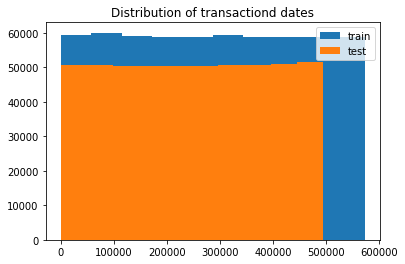

In [32]:
plt.hist(df_train['TransactionDT'], label='train');
plt.hist(df_test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

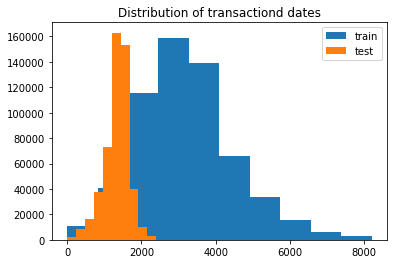

In [33]:
plt.hist(df_train['TransactionAmt'], label='train');
plt.hist(df_test['TransactionAmt'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

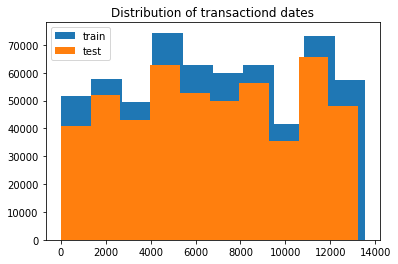

In [34]:
plt.hist(df_train['card1'], label='train');
plt.hist(df_test['card1'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');


# 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환하는 또다른 방법
## fastai_structured, proc_df사용하기
- 카테고리형 데이터를 수치형 데이터로 바꾸고
- 누락 된 연속 값을 처리하고
- 종속 변수를 별도의 변수로 분할

In [35]:
import fastai_structured
fastai_structured.train_cats(df_train)
fastai_structured.apply_cats(df_test, df_train)

In [36]:
nas = {}
# proc_df: 데이터 프레임 df_train을 가져와서 response 변수를 분리하고 df를 전체 숫자 데이터 프레임으로 변경
df_trn, y_trn, nas = fastai_structured.proc_df(df_train, 'isFraud', na_dict=nas)  
df_test, _, _ = fastai_structured.proc_df(df_test, na_dict=nas)
df_trn.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,0,0,3000,4,10095,260,42,1,38,1,166,62,19,37,31,31,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,97,13,39,10,3,0,875,16,13,...,0,4182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12668,3587,19519,3975,13,13,13,13,11,10,11,10,6,6,6,6
1,1,1,1804,4,1372,303,42,2,2,1,173,62,8,37,16,31,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,97,8,13,10,3,0,875,16,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4527,3157,2230,2961,13,13,13,13,11,10,11,10,4,0,6,6
2,2,2,2782,4,2833,389,42,4,58,2,178,62,287,37,36,31,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,97,8,13,10,3,0,875,16,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72097,5097,74199,5232,8249,906,100678,1074,4184,409,14717,477,5,0,6,6
3,3,3,2511,4,13341,466,42,2,14,2,282,62,8,37,54,31,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,107,0,3,0,875,16,84,...,1872,10282,7907,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44946,4580,31768,4375,6038,397,40888,411,2926,161,6005,198,9,0,6,6
4,4,4,2511,1,2712,413,42,2,2,1,241,62,8,37,16,31,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,97,8,39,10,3,0,875,16,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60547,4580,99169,4375,5474,193,28753,201,2406,128,4303,154,4,0,6,6


In [37]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,0,0,1014,4,7171,11,45,4,94,2,45,59,1,44,16,31,6,6,0,0,3,4,0,0,6,0,5,1,115,6,419,419,27,398,27,0,0,864,16,418,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2920,1936,26610,2447,7315,976,94722,1268,4556,500,18317,581,4,0,6,6
1,1,1,1233,4,2469,11,45,4,94,2,129,59,4,44,2,31,3,2,0,0,0,1,0,0,2,0,1,1,12,2,149,149,7,634,7,0,0,864,16,231,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2896,2448,10032,3305,8351,1374,112692,1892,5538,744,27804,873,0,0,6,6
2,2,2,1580,4,2623,470,45,4,94,2,243,59,1863,44,19,31,2,2,0,0,0,5,0,0,4,0,2,0,22,2,137,137,10,97,10,0,0,864,16,136,...,0,0,0,0,2712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5099,4180,115058,6293,5323,269,30382,315,2798,133,4879,173,5,0,6,6
3,3,2,1711,4,7617,258,45,4,53,2,68,59,17,44,16,31,5,2,0,0,1,1,0,0,2,0,2,0,7,4,42,42,41,242,41,0,0,864,16,242,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6123,4842,115486,7269,7841,619,71707,754,4006,309,11703,370,4,0,6,6
4,4,3,1344,4,12956,350,45,2,12,2,103,59,6,44,16,31,6,6,0,0,2,5,0,0,5,0,6,0,14,6,22,22,0,22,0,0,0,864,16,22,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3716,2983,32714,4144,3547,71,9804,80,1003,31,1207,47,4,0,6,6


# 많은 클래스의 데이터 수를 감소시키는 Undersampling 사용

In [38]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler(return_indices=True) ##intialize to return indices of dropped rows
# df_trn_sm,y_trn_sm,dropped = ran.fit_sample(df_trn,y_trn)
df_trn_sm,y_trn_sm,dropped = ran.fit_sample(df_trn,y_trn)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# train/validation set 나누기

In [39]:
train_X, val_X, train_y, val_y = train_test_split(df_trn_sm, y_trn_sm, test_size=0.3)

In [40]:
# # from sklearn.model_selection import train_test_split
# # from sklearn.metrics import roc_auc_score
# # X = df_train.sort_values('TransactionDT').drop(['TransactionDT','isFraud'], axis=1)
# # y = df_train.sort_values('TransactionDT')['isFraud']
# # x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
# # df_test = df_test.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)
# y_train = df_train['isFraud'].copy()

# # Drop target, fill in NaNs
# x_train = df_train.drop('isFraud', axis=1)
# x_test = df_test.copy()
# # x_train = x_train.fillna(-999)
# # x_test = x_test.fillna(-999)


# random forest & grid search
## xgb보다 랜덤포레스트가 더 나았음

In [41]:
%%time
# xgb의 흔적...
# import xgboost as xgb
# clf = xgb.XGBClassifier(n_estimators=100,
#                         n_jobs=-1,
#                         max_depth=6,
#                         learning_rate=0.005,
#                         subsample=0.9,
#                         colsample_bytree=0.9,
#                         missing=-999)

# clf.fit(train_X, train_y)

# forest = RandomForestClassifier(random_state=1, n_estimators=5)
# 난수 seed 설정, 클래스 가중치
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
rf_param_grid = {
    # 'max_depth': [1, 6, 8, 12],
    # 'max_features': [0.3],
    # 'n_estimators': [400]
    'max_depth': [5, 10, 100],
    'n_estimators': [100, 200, 300]
}

rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3, refit='True' ,n_jobs=-1,scoring='roc_auc',verbose=1)
rf_grid_search.fit(train_X, train_y)

rf_gs_res = rf_grid_search.cv_results_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.0min finished


CPU times: user 1min 11s, sys: 802 ms, total: 1min 12s
Wall time: 2min 16s


# forest.fit()에 훈련 데이터를 입력해 Random Forest 모듈을 학습
# submission evaluation 기준이 roc이므로 이에 대해 train/validation 스코어 계산

In [42]:
from sklearn.metrics import roc_auc_score

def print_score(m):
    res = [roc_auc_score(m.predict(train_X), train_y), roc_auc_score(m.predict(val_X), val_y)]
    print(res)

forest.fit(train_X, train_y)
print_score(forest)


[1.0, 0.848931928885812]


# 제출용 csv 파일 만들기

In [43]:
sample_submission = pd.read_csv('/gdrive/MyDrive/data/ieee-fraud-detection/sample_submission.csv')

In [44]:
pred = forest.predict_proba(df_test)[:,1]

In [45]:
sample_submission['isFraud'] = pred   
sample_submission.to_csv('result18.csv', index=False) # 제출

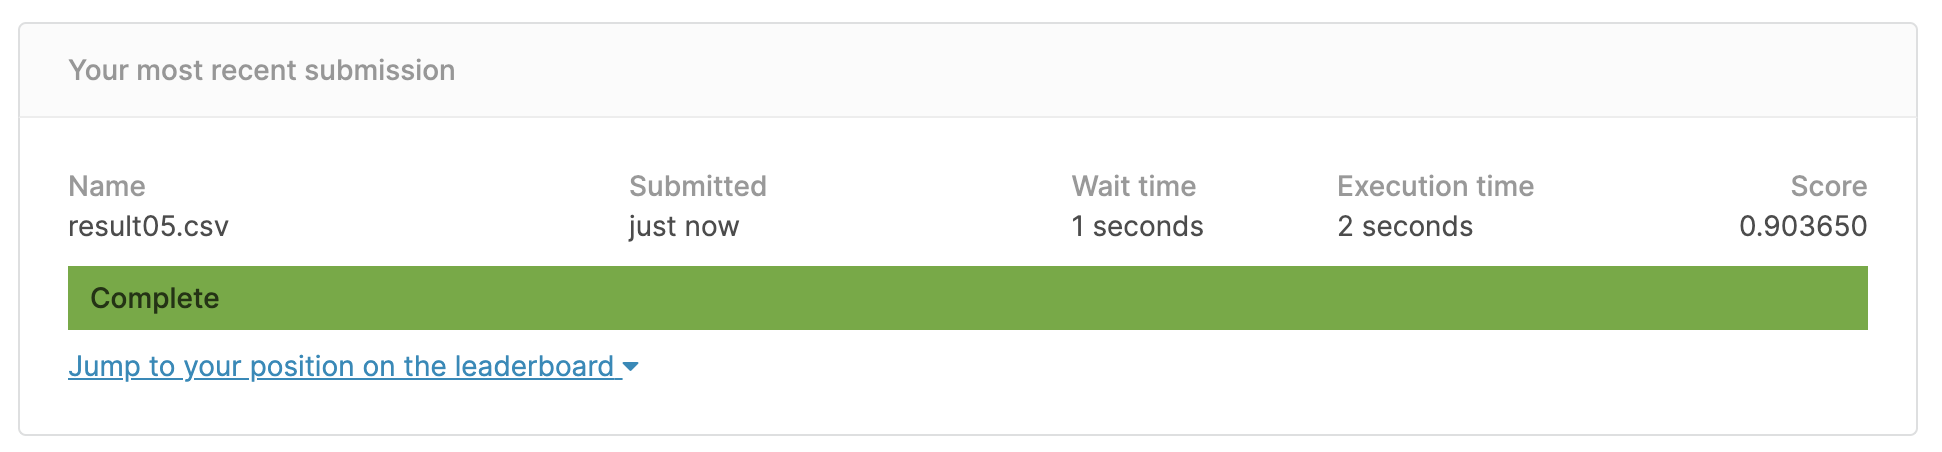